# Analyzing output of pre-trained models

This notebook loads some pre-trained weights for the warping network, which performs the redshift-space distortion to produce the Lya flux field in redshift space. There is some data required for this notebook to work, see this repo's README for download instructions.

First, we import packages and load the pre-trained weights into the network:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print(tf.__version__)
import sys
import os
import time
from warping_net import DM2Flux
import numpy as np
import matplotlib.pyplot as plt
import h5py


# Build model (use dummy pathnames since we are loading pre-trained weights)
expDir = 'n/a'
datapath = 'n/a'
net = DM2Flux(datapath, expDir, resuming=True)

# Load pre-trained weights
net.checkpoint.restore(os.path.join('./trained_models', 'warping_net'))
print('Loaded succesfully')

2.0.0-beta1


W1015 16:17:30.356658 46912496586112 deprecation.py:323] From /usr/common/software/tensorflow/gpu-tensorflow/2.0.0-beta-py36/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:505: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


DONE


---
Next, we will load the necessary data from the validation set region of the simulation. In this case, the data consits of the generated real-space Lya flux field (output of the flux mapping network), the baryon z velocity field, and the target redshift-space Lya flux field.

In [2]:
FTreal = np.squeeze(np.load('./data/generated_Lya_realspace.npy'), axis=0)
with h5py.File('./data/univ_000_real.hdf5', 'r') as hf:
    DM = hf['DM'][:,896:,:].astype(np.float32)
with h5py.File('./data/univ_000_VTFT.hdf5', 'r') as hf:
    redFT = hf['FT'][:,896:,:].astype(np.float32)
    VT = hf['VT'][:,896:,:].astype(np.float32)
print('Loaded samples')
print(FTreal.shape, redFT.shape, VT.shape, DM.shape)

Loaded samples
(1024, 128, 1024, 1) (1024, 128, 1024, 1) (1024, 128, 1024, 2) (1024, 128, 1024)


## Generating Lya redshift-space flux predictions

Here, we generate our predicitons for the Lya redshift-space flux field slice-by-slice, sliding down the x-axis of the simulation. After generation, the slices are recombined back into a 3D array for processing. The mean absolute error (MAE) between the generated and target fields is printed upon completion.

In [3]:
gens = []
tars = []
size = 128
for idx in range(1024):
    # Concatenate generated Lya real-space flux slice with baryon z velocity
    inVZ = np.expand_dims(VT[idx], 0)[:,:,:,1]
    inVZ = np.expand_dims(inVZ, axis=-1)
    inFTreal = np.expand_dims(FTreal[idx], 0)
    inp = np.concatenate([inFTreal, inVZ], axis=-1)
    
    # Generate Lya redhsift-pace 128x1024 slice
    gen = net.generator(inp)
    tar = np.expand_dims(redFT[idx], 0)
    DMslice = DM[idx]
    gens.append(gen)
    tars.append(tar)

DMslice = 2.*(DMslice+1.) # re-normalize dark matter units for plotting
gens = np.concatenate(gens, axis=0)
tars = np.concatenate(tars, axis=0)
print(gens.shape, tars.shape)
print(np.mean(np.abs(gens - tars)))

(1024, 128, 1024, 1) (1024, 128, 1024, 1)
0.02178747


## Visualization

To see the output, and compare to the target field, we will visualize a sample slice of input dark matter, and the real and generated Lya redshift-space flux fields.

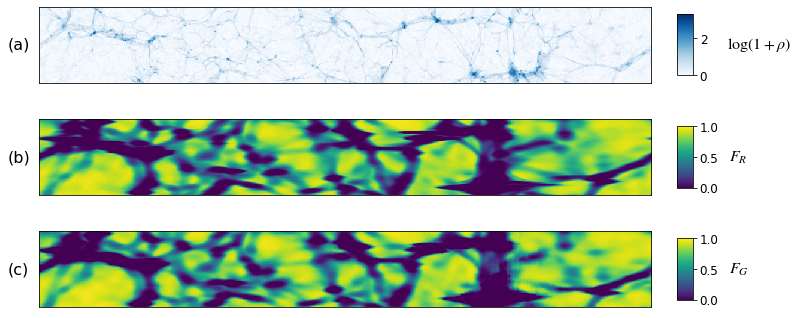

In [8]:
from matplotlib.colors import Normalize
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'stix'
font = 16.

f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'hspace':0.1}, figsize=(12,6))
img = a0.imshow(DMslice, cmap='Blues')
a0.get_xaxis().set_ticks([])
a0.get_yaxis().set_ticks([])
a0.set_ylabel('(a)', fontsize=font, rotation=0, labelpad=20, va='center')
cbar = f.colorbar(img, ax=a0, fraction=0.046, pad=0.04, aspect=4, shrink=0.6)
cbar.set_label(r'$\log (1+ \rho)$', fontsize=font, rotation=0, va='center', ha='left', labelpad=20)

img = a1.imshow(np.squeeze(tar), cmap='viridis', norm=Normalize(vmin=0., vmax=1.))
a1.get_xaxis().set_ticks([])
a1.get_yaxis().set_ticks([])
a1.set_ylabel('(b)', fontsize=font, rotation=0, labelpad=20, va='center')
cbar = f.colorbar(img, ax=a1, fraction=0.046, pad=0.04, aspect=4, shrink=0.6)
cbar.set_label(r'$F_R$', fontsize=font, rotation=0, va='center', ha='left', labelpad=10)

img = a2.imshow(np.squeeze(gen), cmap='viridis', norm=Normalize(vmin=0., vmax=1.))
a2.get_xaxis().set_ticks([])
a2.get_yaxis().set_ticks([])
a2.set_ylabel('(c)', fontsize=font, rotation=0, labelpad=20, va='center')
cbar = f.colorbar(img, ax=a2, fraction=0.046, pad=0.04, aspect=4, shrink=0.6)
cbar.set_label(r'$F_G$', fontsize=font, rotation=0, va='center', ha='left', labelpad=10)

plt.show()

## Flux PDF computation

We can compute the flux PDF by histogramming the values of the flux field across the entire validation set region. The KS-test provides a simple test of the similarity of the flux PDF for the generated and target fields -- here we print the KS-score as well as the p-value.

In [9]:
from scipy.stats import ks_2samp
tar_hist, bin_edges = np.histogram(tars, bins=50)
gen_hist, _ = np.histogram(gens, bins=bin_edges)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2

tar_hist = tar_hist/np.sum(tar_hist)
gen_hist = gen_hist/np.sum(gen_hist)

K, p = ks_2samp(tar_hist, gen_hist)
print(K,p)

0.04000000000000001 0.9999999999973651


Plotting the flux PDF of our target and predicted fields, we see a very tight agreement, with a mean absolute relative error of less than 1 percent. The vertical bars denote a typical dynamic range of flux values relevant to Lya flux analysis (see Sorini et al. 2016)

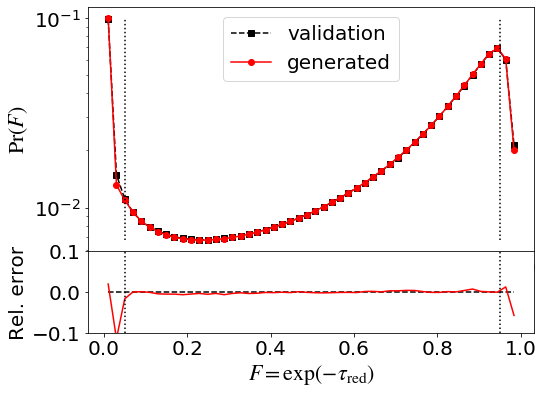

0.0065727263667596115


In [10]:
font = 22.
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.style'] = 'normal'
plt.rcParams['font.size'] = 20

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace':0}, figsize=(8,6))
a0.plot(centers, tar_hist, 'ks--', label='validation')
a0.plot(centers, gen_hist, 'ro-', label='generated')
a0.plot([0.05,0.05], [np.min(tar_hist), np.max(tar_hist)], 'k:')
a0.plot([0.95,0.95], [np.min(tar_hist), np.max(tar_hist)], 'k:')
a0.set_ylabel('$\mathrm{Pr}(F)$', fontsize=font)
a0.set_yscale('log')
a0.legend()


a1.plot([centers[0], centers[-1]], [0, 0], 'k--')
a1.plot(centers, (gen_hist - tar_hist)/tar_hist, 'r-')
a1.plot([0.05,0.05], [-0.1, 0.1], 'k:')
a1.plot([0.95,0.95], [-0.1, 0.1], 'k:')
a1.set_ylim((-0.1,0.1))
a1.set_ylabel(r'Rel. error', fontsize=font-2)
a1.set_xlabel(r'$F=\exp(-\tau _\mathrm{red}) $', fontsize=font)
plt.show()
print(np.mean(np.abs((gen_hist - tar_hist)/tar_hist)))


## Power spectrum computation

Next, we will compute some 1D power spectra of the target and generated fields. To do this, we randomly sample 50,000 individual 1D skewers running the length of the z-axis, and compute power spectra for each skewer. We truncate the power spectra to k<13 km/s, which is a range of length scales relevant to this work (again, see Sorini et al. 2016). Above k<13 km/s, the tight agreement of our model begins to degrade.

In [11]:
from scipy import fftpack
boxsize = 20.
gridsize = 1024.
h = 0.670386

def normalize(skewer):
    flux_mean=np.mean(skewer)
    flux_skewer=skewer/flux_mean
    return flux_skewer
    
def dF_Power_1d(flux_skewer):
    ftdF1 = fftpack.fftshift(fftpack.fftn(flux_skewer.astype(np.float64)))
    ps=(np.abs(ftdF1))**2
    pixelsize = np.float(boxsize)/np.float(gridsize)
    ps *= pixelsize**2/boxsize
    return ps

def bin_data(ps,kbins):
    kmin=2.*np.pi/boxsize*h
    kmax=np.pi*gridsize/boxsize*h
    n=np.arange(len(ps))
    center=n.max()/2.
    k=2.*np.pi*(n-center)/boxsize*h
    bins2=np.linspace(kmin,kmax,kbins+1)

    ### bin powerspectra ###
    dk=(bins2[1:]-bins2[:-1])/2.
    binned_data=np.histogram(k.flatten(),bins=bins2,weights=ps.flatten())[0]
    nmodes=np.histogram(k.flatten(),bins=bins2)[0].astype('float')
    binned_data/=nmodes
    return binned_data, bins2[:-1]+dk

tar_spectra = []
gen_spectra = []
for i in range(50000):
    idx = np.random.randint(len(tars))
    iy = np.random.randint(128)
    normed_skwr = normalize(tars[idx,iy,:,0])
    ps = dF_Power_1d(normed_skwr)
    binned, k = bin_data(ps, 500)
    tar_spectra.append(binned)
    normed_skwr = normalize(gens[idx,iy,:,0])
    ps = dF_Power_1d(normed_skwr)
    binned, k = bin_data(ps, 500)
    gen_spectra.append(binned)
    

tar_spectra = np.stack(tar_spectra, axis=0)
gen_spectra = np.stack(gen_spectra, axis=0)
print(tar_spectra.shape, gen_spectra.shape)

tar_mean = np.mean(tar_spectra, axis=0)
tar_std = np.std(tar_spectra, axis=0)
gen_mean = np.mean(gen_spectra, axis=0)
gen_std = np.std(gen_spectra, axis=0)

# Truncate power spectra to k<13 km/s, the relevant length scales
cut = np.argmin(np.abs(k - 13.))
tar_mean = tar_mean[:cut]
gen_mean = gen_mean[:cut]
k = k[:cut]

(50000, 500) (50000, 500)
12.80222687097777


Here we plot the mean 1D power spectrum for the target and generated fields, again finding a very good agreement across the relevant length scales. The mean absolute relative error here is about 1%.

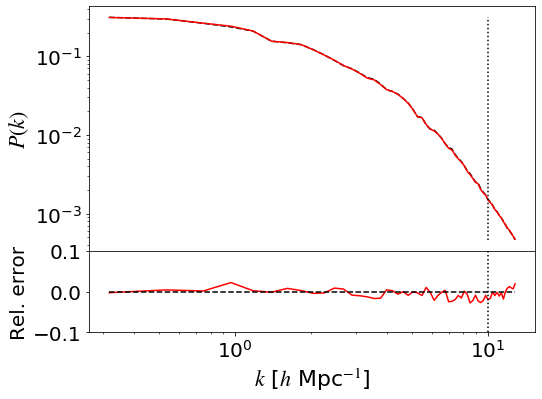

0.010035811199873216


In [12]:
f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1], 'hspace':0}, figsize=(8,6))
a0.plot(k, tar_mean, 'k--', label='validation')
a0.plot(k, gen_mean, 'r-', label='generated')
a0.plot([10,10], [np.min(tar_mean), np.max(tar_mean)], 'k:')
a0.set_yscale('log')
a0.set_xscale('log')
a0.set_ylabel(r'$P(k)$', fontsize=font)


a1.plot(k, (gen_mean - tar_mean)/tar_mean, 'r-')
a1.plot([k[0], k[-1]], [0., 0.], 'k--')
a1.plot([10,10], [-0.1, 0.1], 'k:')
a1.set_xlabel('$k$ [$h$ Mpc$^{-1}$]', fontsize=font)
a1.set_ylabel(r'Rel. error', fontsize=font-2)
a1.set_xscale('log')
a1.set_ylim((-0.1,0.1))
plt.show()

print(np.mean(np.abs((gen_mean - tar_mean)/tar_mean)))
